In [24]:
import os
import numpy as np
import random

class numeric_dataset():
    def __init__(self):
        self.x = None
        self.y = None
        pass
    
    def next_batch(self, batch_size):
        pass
    
class ml_dataset():
    def __init__(self):
        self.train = None
        self.test = None
        
class mit_bih_data_maker():
    def __init__(self):
        self.signal_dir = None
        self.ann_dir = None
        self.rpeak_dir = None
        self.raw_data = {}
        pass
    
    def config(self, signal_dir, ann_dir, rpeak_dir):
        self.signal_dir = signal_dir
        self.ann_dir = ann_dir
        self.rpeak_dir = rpeak_dir
        
    def load_data(self, rec_list = []):
        if self.signal_dir == None or self.ann_dir == None or self.rpeak_dir == None:
            return False
        for f in os.listdir(self.signal_dir):
            if not f.endswith(".dat"):
                continue
            rec_no = ".".join(f.split(".")[0:-1])
            if rec_list != [] and rec_list != None and rec_no not in rec_list:
                continue
            signal_fp = open(os.path.join(self.signal_dir, rec_no + ".dat"))
            ann_fp = open(os.path.join(self.ann_dir, rec_no + ".ann"))
            rpeak_fp = open(os.path.join(self.rpeak_dir, rec_no + ".rpeak"))
            
            if signal_fp == None or ann_fp == None or rpeak_fp == None:
                return False

            #load the signal, ann, rpeak from original file
            signal_array = []
            ann_dict = {}
            rpeak_array = []
            signal_fp.readline()
            signal_fp.readline()
            for line in signal_fp:
                signal_array.append(float(line.rstrip("\r\n").split()[1]))
            signal_fp.close()
            
            ann_fp.readline()
            for line in ann_fp:
                f = line.rstrip("\r\n").split()
                ann_dict[int(f[1])] = f[2]
            ann_fp.close()
    
            for line in rpeak_fp:
                rpeak_array.append(int(line.rstrip("\r\n").split()[1]))
            rpeak_fp.close()
            
            self.raw_data[rec_no] = {}
            self.raw_data[rec_no]["signal"] = signal_array
            self.raw_data[rec_no]["ann"] = ann_dict
            self.raw_data[rec_no]["rpeak"] = rpeak_array
            
        return True
    
    def calc_sample_num(self, total_num, sample_num, label_percent):
        if sample_num == -1 and label_percent == {}:
            return total_num
        
        if label_percent == {}:
            all_num = sum(total_num.value())
            if sample_num >= all_num:
                return total_num
            each_label_num = {}
            for label in total_num:
                each_label_num[label] = int(total_num[label] * float(sample_num) / total_num)
            return each_label_num
        
        if sample_num == -1:
            for label in total_num:
                vir_sample_num = int(total_num[label] / label_percent[label])
                if sample_num == -1 or vir_sample_num < sample_num:
                    sample_num = vir_sample_num
                    
        each_label_num = {}
        for label in label_percent:
            each_label_num[label] = int(sample_num * label_percent[label])
            
        return each_label_num
        
    def split(self, dataset, train_percent):
        train_data = numeric_dataset()
        test_data = numeric_dataset()
        
        idx = range(dataset.x.shape[0])
        
        train_idx = set(random.sample(idx, int(dataset.x.shape[0] * train_percent)))
        
        train_x_array = []
        train_y_array = []
        test_x_array = []
        test_y_array = []
        print dataset.x.shape
        for i in xrange(dataset.x.shape[0]):
            if i in train_idx:
                train_x_array.append(dataset.x[i])
                train_y_array.append(dataset.y[i])
            else:
                test_x_array.append(dataset.x[i])
                test_y_array.append(dataset.y[i])
                
        train_data.x = np.array(train_x_array)
        train_data.y = np.array(train_y_array)
        test_data.x = np.array(test_x_array)
        test_data.y = np.array(test_y_array)
        
        return (train_data, test_data)
        
    def make_by_r_peak(self, before_r, after_r, sample_num = -1, label_maker = None, label_percent = {}, train_percent = 0.8):
        #before_r in clude the r_peak point
        
        #merge rpeak and ann
        rpeak_label = {}
        for rec_no in self.raw_data:
            rpeak_label[rec_no] = {}
            for rpeak in self.raw_data[rec_no]["rpeak"]:
                if rpeak - before_r + 1 < 0 or rpeak + after_r >= len(self.raw_data[rec_no]["signal"]):
                    continue
                min_dist = 1000000
                label = None
                for idx in xrange(rpeak - before_r + 1, rpeak + after_r + 1):
                    if idx in self.raw_data[rec_no]["ann"]:
                        if abs(idx - rpeak) < min_dist:
                            min_dist = abs(idx - rpeak)
                            label = self.raw_data[rec_no]["ann"][idx]
                if label_maker != None:
                    new_label = label_maker(label)
                else:
                    new_label = label
                if new_label == "Omit":
                    continue
                rpeak_label[rec_no][rpeak] = new_label
                
        #merge rpeak_label and signal
        label_data_dict = {}
        for rec_no in rpeak_label:
            for rpeak in rpeak_label[rec_no]:
                label = rpeak_label[rec_no][rpeak]
                if label not in label_data_dict:
                    label_data_dict[label] = []
                start = rpeak - before_r + 1
                end = rpeak + after_r + 1
                label_data_dict[label].append(self.raw_data[rec_no]["signal"][start:end])
                
        #calc the sample num for each label
        total_num = {}
        for label in label_data_dict:
            total_num[label] = len(label_data_dict[label])
        each_label_num = self.calc_sample_num(total_num, sample_num, label_percent)
        
        #sample from label_data_dict
        sampled_xy = []
        for label in label_data_dict:
            sampled_data_by_label = random.sample(label_data_dict[label], each_label_num[label])
            for s in sampled_data_by_label:
                sampled_xy.append({"x":s, "y":label})
        random_xy = random.sample(sampled_xy, len(sampled_xy))
        x_array = []
        y_array = []
        for r in random_xy:
            x_array.append(r["x"])
            y_array.append(r["y"])
        all_dataset = numeric_dataset()
        all_dataset.x = np.array(x_array)
        all_dataset.y = np.array(y_array)
        
        ret_dataset = ml_dataset()
        (ret_dataset.train, ret_dataset.test) = self.split(all_dataset, train_percent)
        
        return ret_dataset

      
data_maker = mit_bih_data_maker()
data_maker.config("../database/mit-bih/", "../database/mit-bih", "../database/mit-bih-r-label")
data_maker.load_data()

def test_label_maker(label):
    label_map = {"N":0, "L":1, "R":2, "V":3, "A":4}
    if label in label_map:
        return label_map[label]
    return "Omit"

ecg_data = data_maker.make_by_r_peak(before_r = 90, after_r = 146, sample_num = -1, label_maker = test_label_maker, label_percent = {}, train_percent = 0.8)

(99503, 236)


<IPython.core.display.Javascript object>


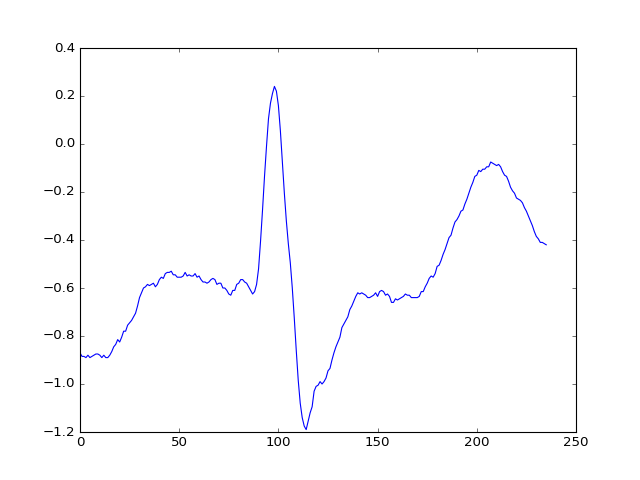

In [47]:
%matplotlib nbagg
import random
import matplotlib.pyplot as plt

label_wanted = 3

idx_wanted = []
for i in xrange(ecg_data.train.x.shape[0]):
    if ecg_data.train.y[i] == label_wanted:
        idx_wanted.append(i)
    
while True:
    idx = random.sample(idx_wanted, 1)[0]
    if ecg_data.train.y[idx] != label_wanted:
        continue
    plt.plot(ecg_data.train.x[idx])
    break